# Classifiez automatiquement des biens de consommation

La mission:

- **réaliser une première étude de faisabilité d'un moteur de classification** d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.
- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et des images, une **réduction de dimension**, puis un **clustering**. Les résultats de la réduction de dimension et du clustering seront à présenter sous la formede graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.
- Démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie


### Importation des données

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

#traitement de texte
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import texthero as hero
from texthero import preprocessing
import pickle
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
import tensorflow_hub as hub


# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'
#traitement d'image
import cv2
from PIL import Image
from matplotlib.image import imread
import skimage.io as io
from sklearn.model_selection import train_test_split
from os import listdir

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


In [2]:
#Chargement du dataset 
data=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
data.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...

#### Les caractéristiques de la table

In [3]:
#Fonction d'observation de chaque table. 
'''
Cette fonction affichera pour chaque dataset, les éléments suivants:
- La dimension de la table,
- Le nombre de données manquantes,
- Les nombre de doublons
- le type de variables, 
- les valeurs uniques de chaque variable
- La répartition des valeurs manquantes par variable

'''

def observation(df,name):
    #les dimmensions 
    dimensions= print("la dimension de la table" ,name, "est de", df.shape)
    #les données manquantes 
    NaN=df.isna().sum().sum()
    print("La somme des valeurs manquantes de la table",name, "est de",NaN)
    #les doublons 
    doublons=df.duplicated().sum()
    print('Le nombre de doubons cette table est de ', doublons)
    #tableau qui résume le type de variables, les valeurs uniques et les valeurs manquantes 
    tableau=pd.DataFrame(df.dtypes, columns=['type de variable'])
    tableau['valeurs uniques']=df.nunique()
    tableau['valeurs manquantes']= df.isna().sum()
    return tableau

In [4]:
observation(data,'data')

la dimension de la table data est de (1050, 15)
La somme des valeurs manquantes de la table data est de 341
Le nombre de doubons cette table est de  0


type de variable  valeurs uniques  valeurs manquantes
uniq_id                           object             1050                   0
crawl_timestamp                   object              149                   0
product_url                       object             1050                   0
product_name                      object             1050                   0
product_category_tree             object              642                   0
pid                               object             1050                   0
retail_price                     float64              354                   1
discounted_price                 float64              424                   1
image                             object             1050                   0
is_FK_Advantage_product             bool                2                   0
description                       object             1050                   0
product_rating                    object               27                   0
overall_rating                    object               27                   0
brand                             object              490                 338
product_specifications            object              984                   1

## Faisabilité de classification – Texte

L’objectif est de vérifier la faisabilité de classifier automatiquement les produits, simplement via une représentation en 2D des produits et une vérification d’une séparation automatique selon leur catégorie réelle (classification non supervisée). 

#### Classement des produits par catégories 

In [5]:
data["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [6]:

list_categories_1, list_categories_2 = [], []
for txt in data["product_category_tree"] :
    
    list_categories_1.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    list_categories_2.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
data["category_1"] = pd.Series(list_categories_1)
data["category_2"] = pd.Series(list_categories_2)

print("Nombre de première catégorie est de {}, Nombre de deuxième catégorie est de {} ".format(data["category_1"].nunique(), data["category_2"].nunique()))

Nombre de première catégorie est de 7, Nombre de deuxième catégorie est de 63 


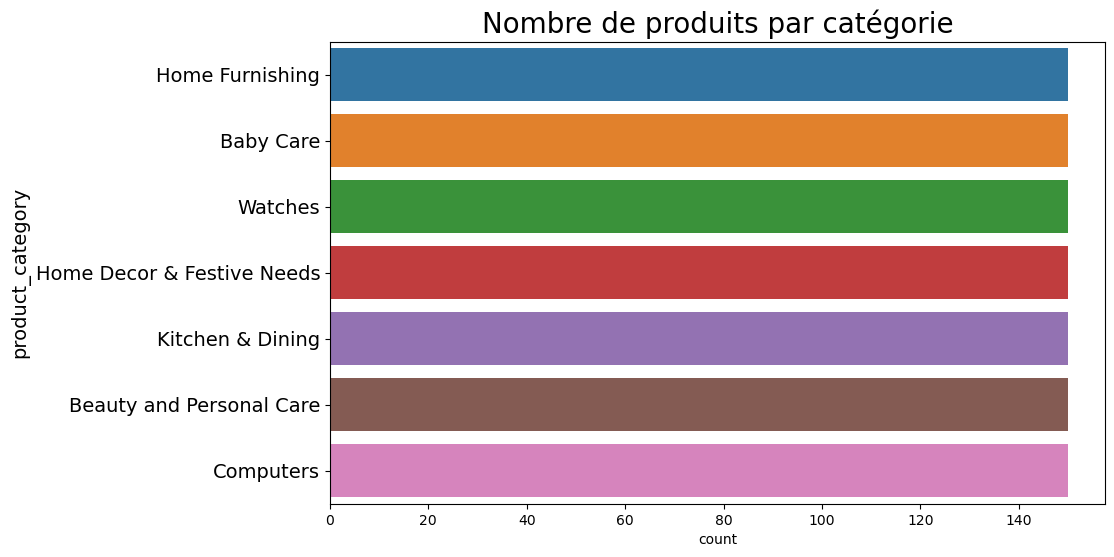

In [7]:
#Regardons le nombre de produits par catégorie (premier niveau)
fig = plt.figure(figsize=(10, 6))
sns.countplot(data=data, y="category_1",
             order = data["category_1"].value_counts().index,)
plt.yticks(size=14)
plt.title(f"Nombre de produits par catégorie",
          fontsize=20)
plt.ylabel("product_category", fontsize=14)
plt.show()


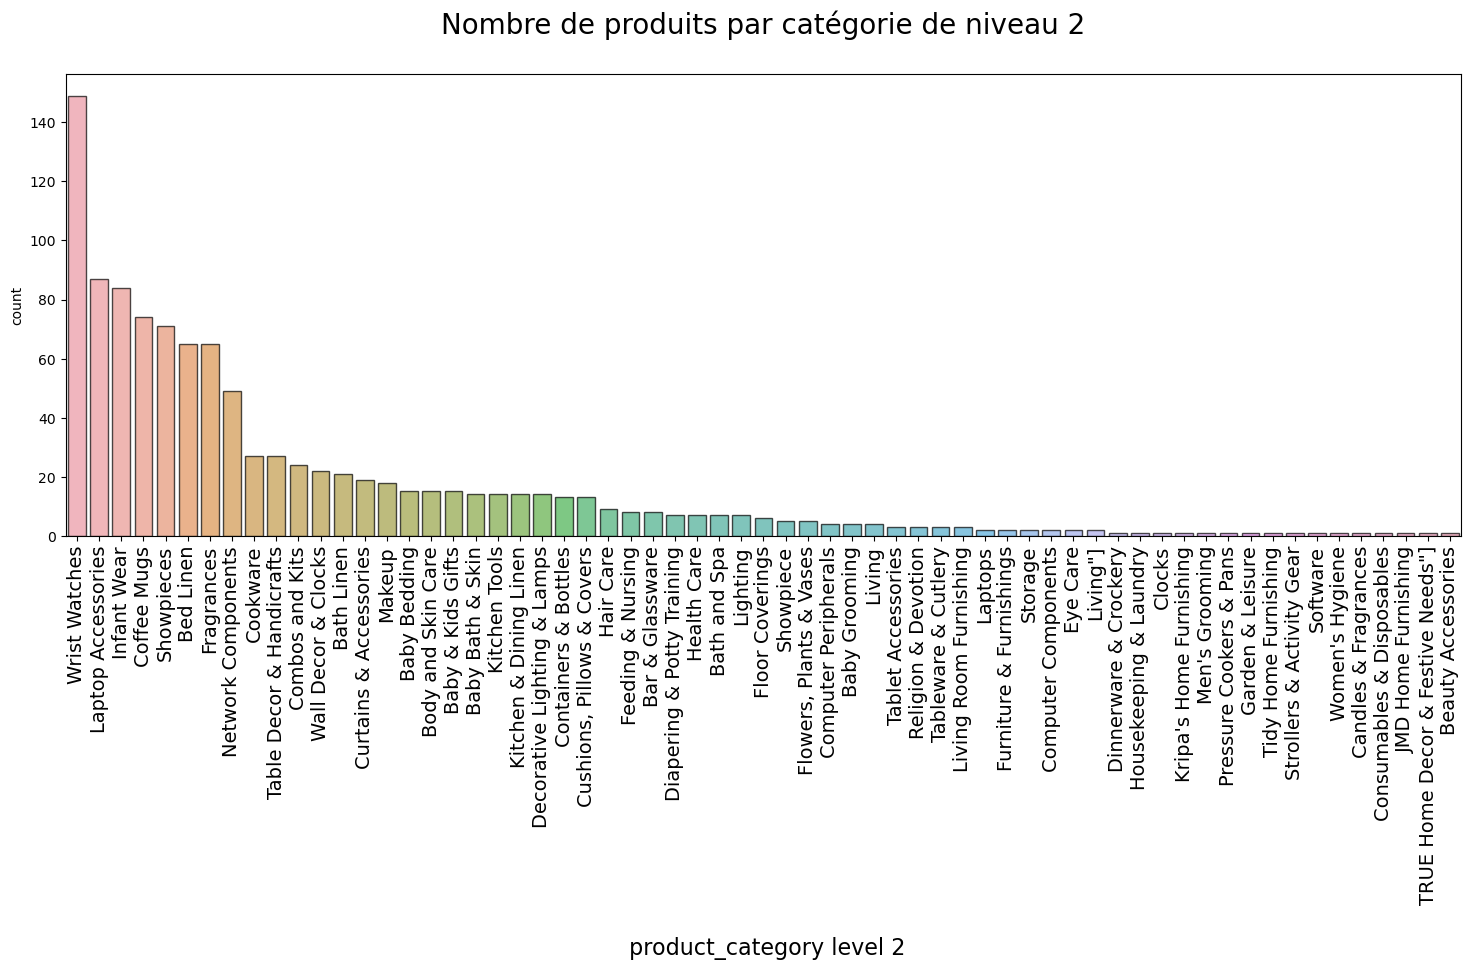

In [8]:
#Regardons le nombre de produits par catégorie (deuxième niveau)
fig = plt.figure(figsize=(18, 6))
sns.countplot(data=data, x="category_2",
              edgecolor="black",
              order = data['category_2'].value_counts().index,
              alpha=0.7)
plt.xticks(rotation=90, size=14)
plt.title(f"Nombre de produits par catégorie de niveau 2\n",
          fontsize=20)
plt.xlabel('\n product_category level 2', fontsize=16)
plt.show()

In [9]:
# Chargement du jeu de données
data.to_csv('data_category.csv',index=False )

In [10]:
# Constitution du dataframe de travail
df = data.copy()[['category_1','product_name','description']]
df.head()

category_1                                       product_name  \
0  Home Furnishing  Elegance Polyester Multicolor Abstract Eyelet ...   
1        Baby Care                         Sathiyas Cotton Bath Towel   
2        Baby Care                Eurospa Cotton Terry Face Towel Set   
3  Home Furnishing  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Home Furnishing  Jaipur Print Cotton Floral King sized Double B...   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [11]:
#Fusion des colonnes
df['product_desc'] = df['product_name']+' '+df['description']
df.head()

category_1                                       product_name  \
0  Home Furnishing  Elegance Polyester Multicolor Abstract Eyelet ...   
1        Baby Care                         Sathiyas Cotton Bath Towel   
2        Baby Care                Eurospa Cotton Terry Face Towel Set   
3  Home Furnishing  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Home Furnishing  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                        product_desc  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Specifications of S...  
2  Eurospa Cotton Terry Face Towel Set Key Featur...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

### Prétraitement de texte

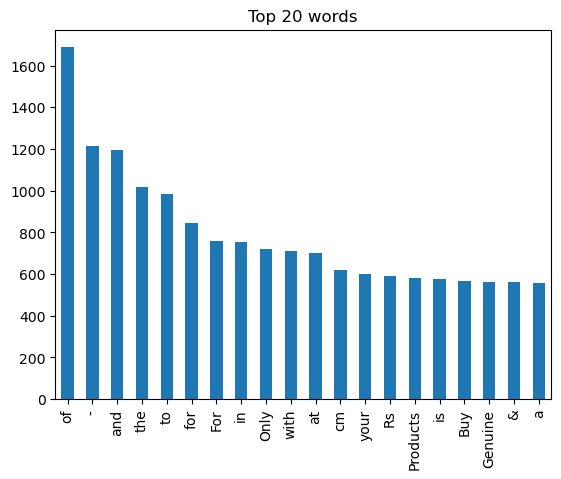

In [12]:
NUM_TOP_WORDS = 20

top_20 = hero.visualization.top_words(df['product_desc']).head(NUM_TOP_WORDS)

# Draw the bar chart

top_20.plot.bar(rot=90, title="Top 20 words");

plt.show(block=True);

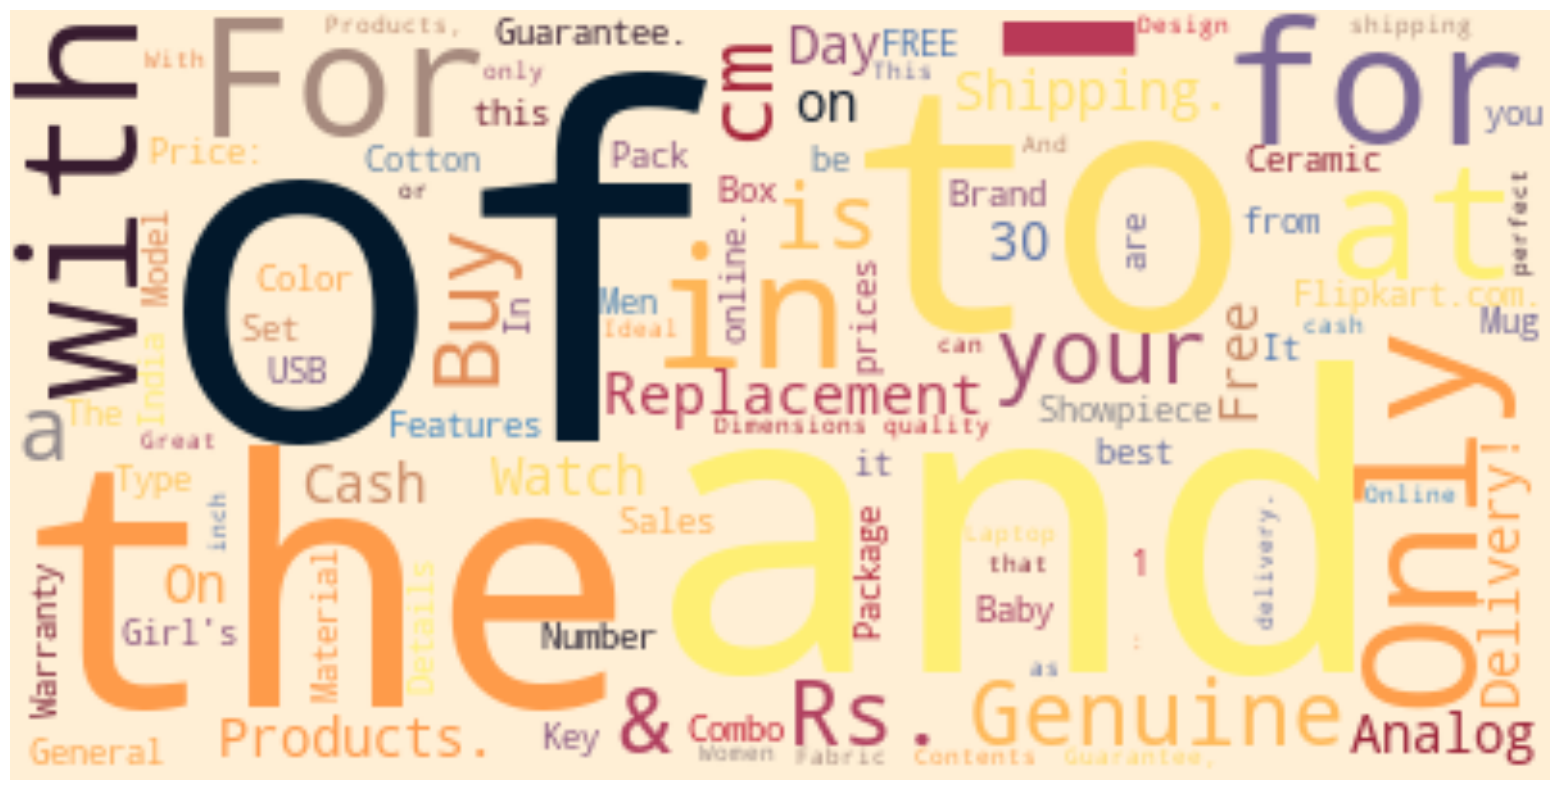

In [13]:
#Plot wordcloud image using WordCloud method
hero.wordcloud(df.product_desc, max_words=100,)

In [14]:
#Premièrement on importe toutes les librairies nécessaires 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mr_ar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mr_ar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mr_ar\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mr_ar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
#Ensuite on initialise
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

#### Fonction de preprocessing

In [16]:
df_desc=df.copy()
#on construit notre fonction de preprocessing
"""Cette fonction permettra d'effectuer les opérations suivantes:
- enlever la ponctuation
- enlever les chiffres
- Tokenisation: transformer les phrases en liste de tokens
- enlever les stopwords (mots n’apportant pas de sens)
- lemmatization (représenter les mots sous leur forme canonique pour ne conserver que le sens des mots utilisés dans le corpus)
- enlever les majuscules
- reformer les phrases avec les mots restants
"""

# Fonction de préparation du texte pour le bag of words avec lemmatization
def Preprocess_listofSentence_bow(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        # enlever la ponctuation
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        # enlever les chiffres
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        # transformer les phrases en liste de tokens
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        # enlever les stopwords (mots n’apportant pas de sens)
        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]
        #lemmatizer        
        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        #enlever les majuscules
        sentence_clean = ' '.join(w for w in words_lemmatize if w.lower() in words or not w.isalpha())
        # reformer les phrases avec les mots restants
        preprocess_list.append(sentence_clean)

    return preprocess_list 


# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def Preprocess_listofSentence_dl(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        # enlever la ponctuation
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        # enlever les chiffres
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        # transformer les phrases en liste de tokens
        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_num)
        # enlever les stopwords (mots n’apportant pas de sens)
#        words_w_stopwords = [i for i in tokenize_sentence if i not in stopwords]
        #lemmatizer        
#        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
        #enlever les majuscules
        sentence_clean = ' '.join(w for w in tokenize_sentence if w.lower() in words or not w.isalpha())
        # reformer les phrases avec les mots restants
        preprocess_list.append(sentence_clean)

    return preprocess_list 


In [17]:
#Application de la fonction de preprocessing 
df_desc['clean_text_bow']=Preprocess_listofSentence_bow(df['product_desc'])
df_desc['clean_text_dl']=Preprocess_listofSentence_dl(df['product_desc'])
print('**Exemple de nettoyage de texte**')
print('Phrase de base : '+df['product_desc'][1])
print('-------')
print('-------')
print('Phrase nettoyée : '+df_desc['clean_text_bow'][1])

**Exemple de nettoyage de texte**
Phrase de base : Sathiyas Cotton Bath Towel Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel
-------
-------
Phrase nettoyée : cotton bath towel specification cotton bath towel bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand type bath towel model name cotton bath towel ideal men woman boy girl model id color red yellow blue size dimension length inch width inch box number content sale package sale package bath towel


In [18]:
#preprocessing des noms des différentes catégories
df_desc['category_1']=Preprocess_listofSentence_bow(df_desc['category_1'])

In [19]:
l_cat = list(set(df_desc['category_1']))
y_cat_num = [(1-l_cat.index(df_desc.iloc[i]['category_1'])) for i in range(len(df_desc))]
print("Catégories : ", l_cat)

Catégories :  ['beauty personal care', 'home festive need', 'home furnishing', 'watch', 'computer', 'baby care', 'kitchen dining']


### Représentation du corpus en Bag of word - Tf-idf

L’approche sac de mots consiste à compter les occurences de chaque mot dans chaque document de la base de données.
CountVectorizer extrait les termes les plus fréquents d'une collection de textes et convertit ces termes en vecteurs de compte de mots.
la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. Il est appelé « inverse document frequency » (idf). 

In [20]:
#calcul des max length

df_desc['length_bow'] = df_desc['clean_text_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df_desc['length_bow'].max())
df_desc['length_dl'] = df_desc['clean_text_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df_desc['length_dl'].max())

max length bow :  333
max length dl :  497


##### Fonction de réduction PCA, de calcul de Tsne et de détermination des clusters

- La **réduction PCA** permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99% dans notre cas)
- Un **T-SNE** permet de réduire à 2 composantes les features, et les afficher en coloriant selon la catégorie réelle.
- Un **clustering k-means** à partir des 2 composantes du T-SNE (7 clusters comme le nombre de catégories) permet de vérifier l’aspect visuel. 
- L’**adjusted Rand Score (ARI)** permet de comparer la similarité de la catégorisation (catégorie réelle / cluster k-means). Sa valeur, de l’ordre de 0.4 à 0.5, confirme le visuel et donc la faisabilité de classer automatiquement les produits.

In [21]:

# réduction PCA ,calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    
    ##réduction PCA 
    #print("Dimensions avant réduction PCA : ", features.shape)
    #pca = decomposition.PCA(n_components=0.99)
    #pca_results= pca.fit_transform(features)
    #print("Dimensions après réduction PCA : ", pca_results.shape) 
    
    #calcul Tsne
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [22]:
#Analyse par catégories
def repartition(labels, feature):
    df_repartition= pd.crosstab( feature, labels , rownames=['categories réelles'],colnames = ['clusters'])
    plt.figure()
    """
    pl=df_repartition.plot(kind='bar', stacked=True, rot=0)
    plt.title('Repartition des catégories par clusters')
    pl.legend(title='categories', bbox_to_anchor=(1, 1.02),
         loc='upper left') """
    plt.show()
    plt.figure()
    plt.title(" Matrice de confusion", fontsize=10, fontweight="bold")
    sns.heatmap(df_repartition,annot=True,fmt="d",cmap='coolwarm')
    plt.show()
    return df_repartition


#### Création du bag of words (CountVectorizer et Tf-idf)

In [23]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# fonction CountVectorizer de sklearn
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
# fonction tf-idf de sklearn
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
feat='clean_text_bow'
# CountVectorizer et tf-idf sur les données prétraitées ()
cv_fit = cvect.fit(df_desc[feat])
ctf_fit = ctf.fit(df_desc[feat])

cv_transform = cvect.transform(df_desc[feat]).toarray()  
ctf_transform = ctf.transform(df_desc[feat]).toarray() 


In [24]:
#réduction PCA- BOW
print("Dimensions avant réduction PCA : ", cv_transform.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bow= pca.fit_transform(cv_transform)
print("Dimensions après réduction PCA : ", pca_results_bow.shape)

Dimensions avant réduction PCA :  (1050, 2963)
Dimensions après réduction PCA :  (1050, 513)


In [25]:
#réduction PCA- tf
print("Dimensions avant réduction PCA : ", ctf_transform.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_tf= pca.fit_transform(ctf_transform)
print("Dimensions après réduction PCA : ", pca_results_tf.shape)

Dimensions avant réduction PCA :  (1050, 2963)
Dimensions après réduction PCA :  (1050, 638)


##### Calcul de Tsne, détermination des clusters et calcul d'ARI entre vrais catégorie et n° de clusters

CountVectorizer : 
-----------------


C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4515 time :  16.0


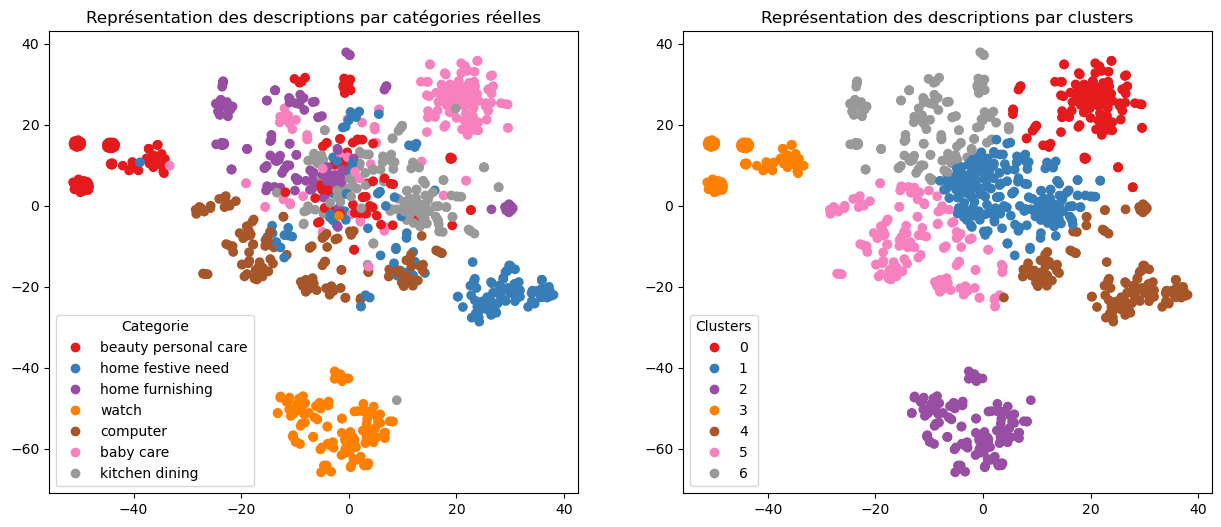

ARI :  0.4515


<Figure size 640x480 with 0 Axes>

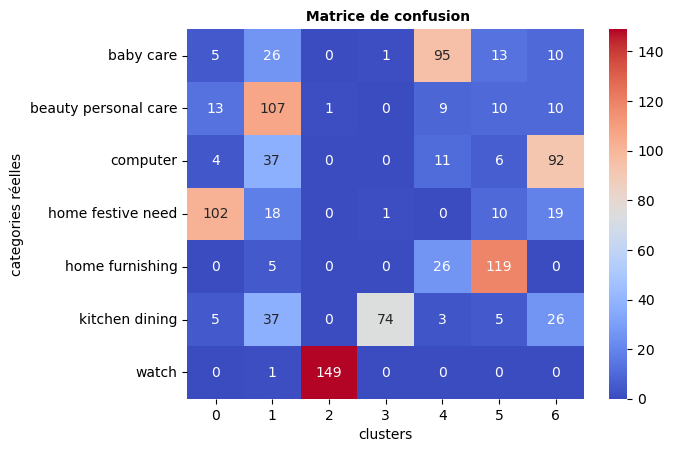

In [26]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(pca_results_bow)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
df_repartition=repartition(labels, df_desc['category_1'])
print()


La  valeur de l’adjusted Rand Score (ARI), de l’ordre de 0.4 à 0.5, confirme le visuel et donc la faisabilité de classer automatiquement les produits.

#### Tf-idf

Tf-idf : 
--------


C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4907 time :  16.0


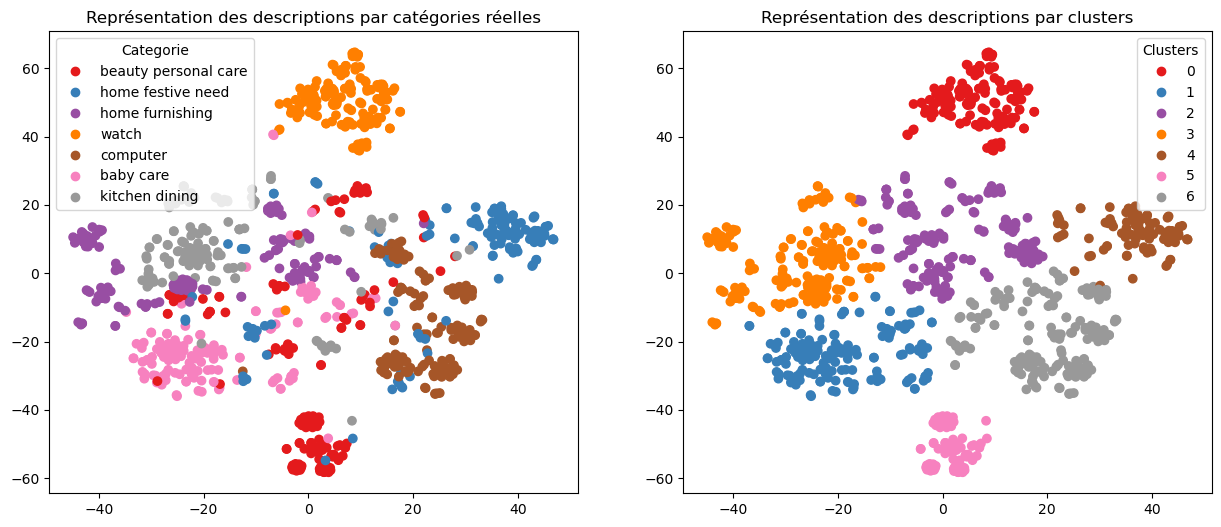

ARI :  0.4907


<Figure size 640x480 with 0 Axes>

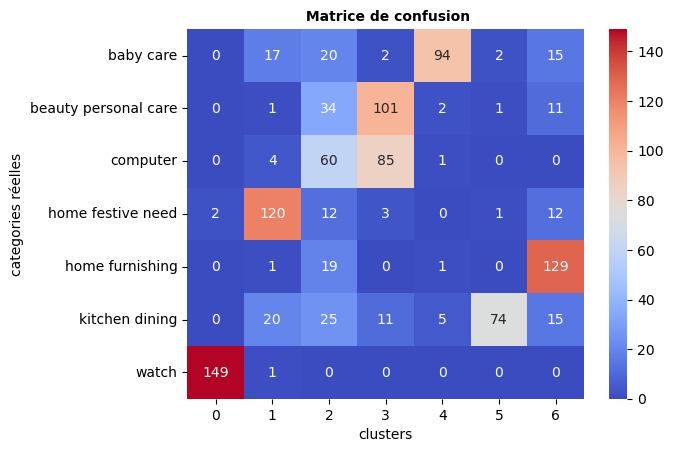

In [27]:

print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(pca_results_tf)
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
df_repartition=repartition(labels, df_desc['category_1'])

In [28]:
df_repartition.to_csv('bag_of_word')

### Le Word Embedding

le word embedding est capable en réduisant la dimension de capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, …) d’un mot.

### Le modèle Word2Vec

word2vec est une sorte d’ACP non linéaire en ce sens qu’il réduit les dimensions.  
Il repose sur des réseaux de neurones à 3 couches (1 couche d’entrée, 1 couche cachée, 1 couche de sortie). Il existe deux variantes du Word2vec, le Continuous Bag Of Words (CBOW) et le Skip-gram.
CBOW : Le modèle est nourri par le contexte, et prédit le mot cible.
Skip Gram : Le modèle est nourri par le mot cible, et prédit les mots du contexte

In [29]:
#Création du modèle Word2Vec
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 333 # adapt to length of sentences
sentences = df_desc['clean_text_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [30]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3072
Word2Vec trained


In [31]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3073


In [32]:

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (3073, 300)


In [33]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)


# Résumé du modèle
embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 300)          921900    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 921,900
Trainable params: 921,900
Non-trainable params: 0
_________________________________________________________________


In [34]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 6ms/step


(1050, 300)

In [35]:
ARI, X_tsne, labels = ARI_fct(embeddings)

C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4113 time :  15.0


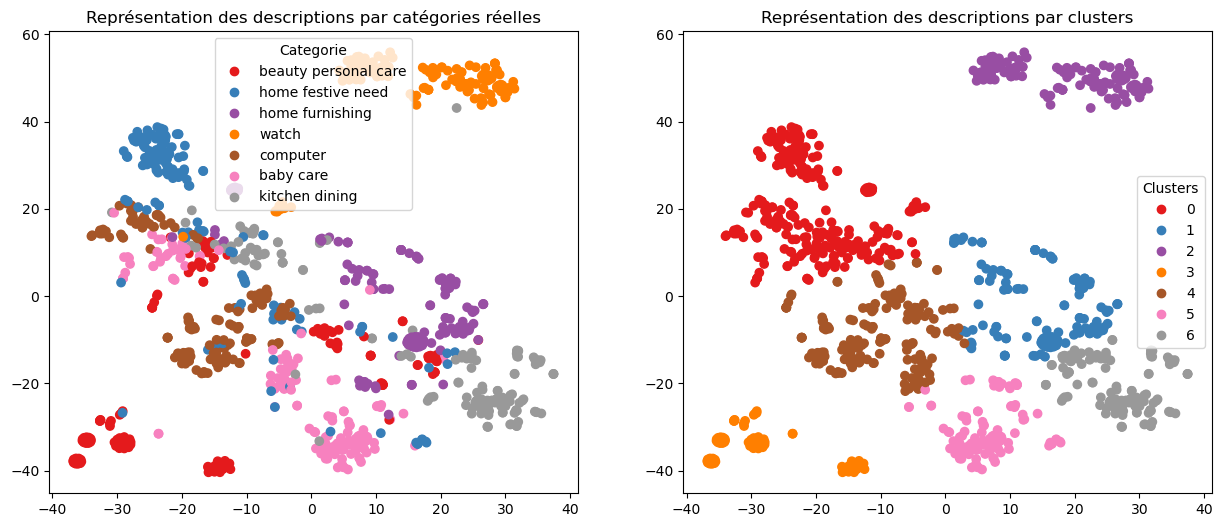

ARI :  0.4113


In [36]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### Analyse par catégories 

<Figure size 640x480 with 0 Axes>

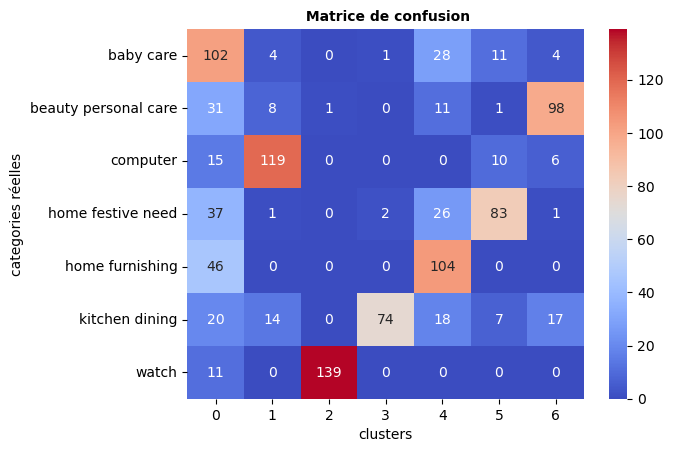

clusters                0    1    2   3    4   5   6
categories réelles                                  
baby care             102    4    0   1   28  11   4
beauty personal care   31    8    1   0   11   1  98
computer               15  119    0   0    0  10   6
home festive need      37    1    0   2   26  83   1
home furnishing        46    0    0   0  104   0   0
kitchen dining         20   14    0  74   18   7  17
watch                  11    0  139   0    0   0   0

In [37]:
repartition(labels, df_desc['category_1'])

### BERT (Bidirectional Encoder Representations from Transformers) 

BERT fait appel à Transformer, un mécanisme d’attention qui apprend les relations contextuelles entre les mots (ou les sous-mots) d’un texte. Dans sa forme classique, Transformer comprend deux mécanismes distincts : un encodeur qui lit le texte en entrée et un décodeur qui produit une prédiction pour la tâche. Puisque l’objectif de BERT est de générer un modèle de langage, seul le mécanisme d’encodage est nécessaire.

Contrairement aux modèles directionnels, qui lisent le texte entré de manière séquentielle (de gauche à droite ou de droite à gauche), l’encodeur Transformer lit la séquence entière de mots en une seule fois. Il est donc considéré comme bidirectionnel, bien qu’il serait plus exact de dire qu’il est non directionnel. Cette caractéristique permet au modèle d’apprendre le contexte d’un mot en se basant sur tout son environnement (à gauche et à droite du mot).

L’entrée est une séquence de tokens, qui sont d’abord intégrés dans des vecteurs, puis traités dans le réseau neuronal. La sortie est une séquence de vecteurs de taille H, dans laquelle chaque vecteur correspond à un token d’entrée avec le même index.

In [38]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [39]:
max_length = 497
batch_size = 50
#La batchsize définit le nombre d'échantillons qui vont être propagés à travers le réseau
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_desc['clean_text_dl'].to_list()

loading configuration file config.json from cache at C:\Users\mr_ar/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\mr_ar/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [40]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\mr_ar/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\mr_ar/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 62s 62s/step
temps traitement :  1286.0


In [41]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.3062 time :  20.0


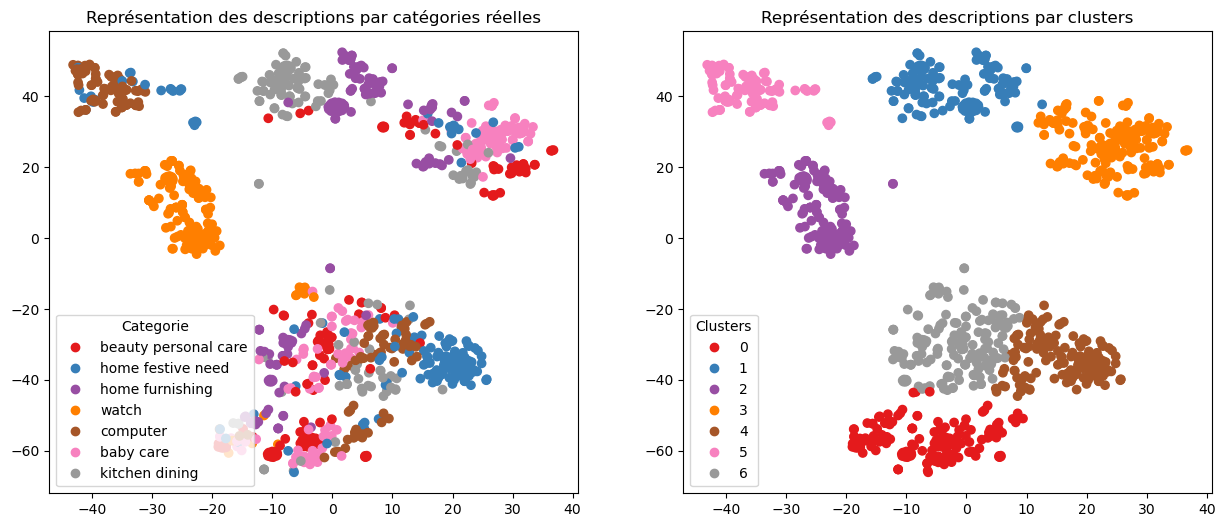

ARI :  0.3062


In [42]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<Figure size 640x480 with 0 Axes>

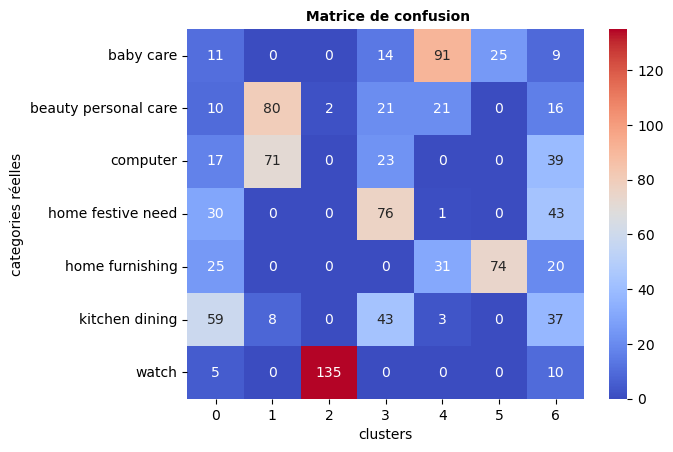

clusters               0   1    2   3   4   5   6
categories réelles                               
baby care             11   0    0  14  91  25   9
beauty personal care  10  80    2  21  21   0  16
computer              17  71    0  23   0   0  39
home festive need     30   0    0  76   1   0  43
home furnishing       25   0    0   0  31  74  20
kitchen dining        59   8    0  43   3   0  37
watch                  5   0  135   0   0   0  10

In [43]:
repartition(labels, df_desc['category_1'])

### USE - Universal Sentence Encoder

Les modèles Universal Sentence Encoder construisent des embeddings de phrase en effectuant une moyenne pondérée des mots contenus. La pondération est issue d’un apprentissage basé sur le concept d’Attention, permettant  d’identifier l’importance des mots dans un contexte en fonction de leur position et de leur identité.

In [44]:
#USE - Universal Sentence Encoder
import tensorflow_hub as hub

embed = hub.load("C:/Users/mr_ar/Downloads/universal-sentence-encoder_4.tar/universal-sentence-encoder_4")
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133016 -0.06338632 -0.01607501 ... -0.03242781 -0.04575741
   0.05370456]
 [ 0.05080862 -0.01652432  0.01573779 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [45]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [46]:
batch_size = 50
sentences = df_desc['clean_text_dl'].to_list()

In [47]:
features_USE = feature_USE_fct(sentences, batch_size)

In [48]:
ARI, X_tsne, labels = ARI_fct(features_USE)

C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4337 time :  18.0


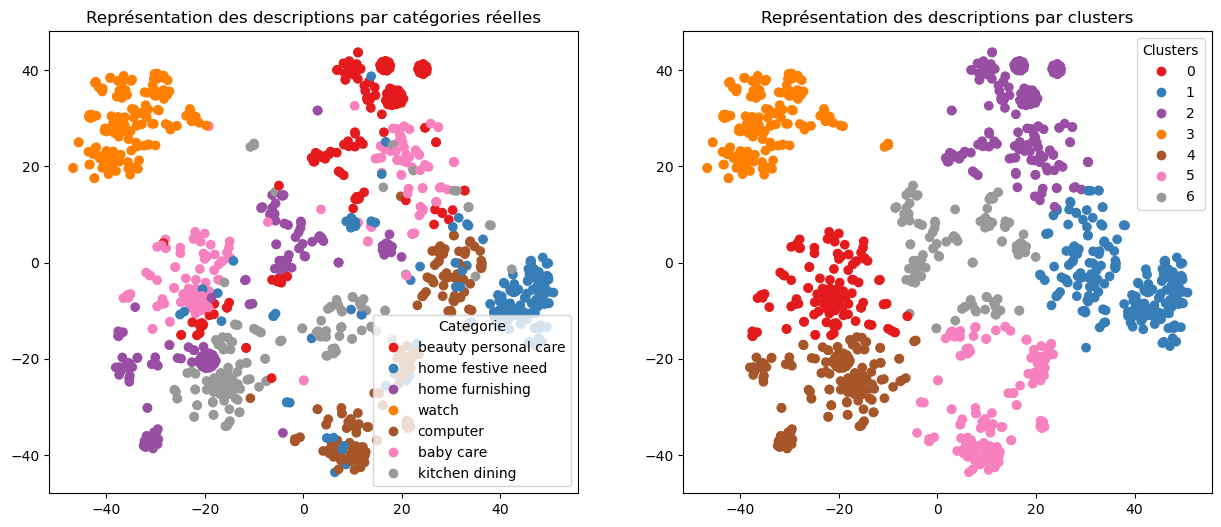

ARI :  0.4337


In [49]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

<Figure size 640x480 with 0 Axes>

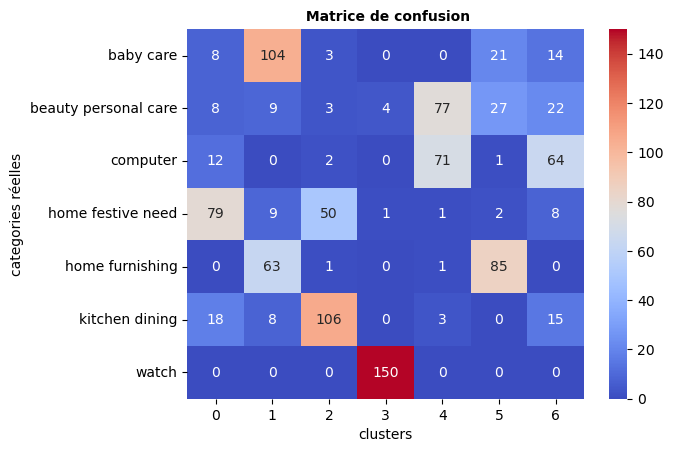

In [50]:
repartition_use=repartition(labels, df_desc['category_1'])

In [51]:
repartition_use

clusters               0    1    2    3   4   5   6
categories réelles                                 
baby care              8  104    3    0   0  21  14
beauty personal care   8    9    3    4  77  27  22
computer              12    0    2    0  71   1  64
home festive need     79    9   50    1   1   2   8
home furnishing        0   63    1    0   1  85   0
kitchen dining        18    8  106    0   3   0  15
watch                  0    0    0  150   0   0   0

## Faisabilité de classification automatique d’images 

In [52]:
#importation des données:
df_img=pd.read_csv('data_category.csv')

In [53]:
#path = r"C:/Users/mr_ar/Downloads/Dataset+projet+prétraitement+textes+images/Images/"
path = "./Images/"
df_img['image_loc'] = [path + row for row in df_img['image']]

In [54]:
#Attribution de numero par cétégories
list_labels = list(set(df_img["category_1"]))

df_image = pd.DataFrame()

df_image["image_path"] = df_img["image"]
df_image["label_name"] = df_img["category_1"]
le = sklearn.preprocessing.LabelEncoder()
df_image["label"] = le.fit_transform(df_image["label_name"])
df_image.head(3)

image_path       label_name  label
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing      4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care      0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care      0

In [55]:
df_image.groupby("label").count()


image_path  label_name
label                        
0             150         150
1             150         150
2             150         150
3             150         150
4             150         150
5             150         150
6             150         150

### Exemple d'image par catégories

-------
Home Furnishing


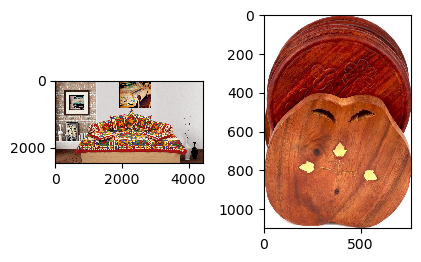

-------
Home Decor & Festive Needs


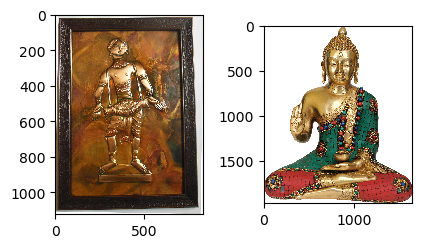

-------
Baby Care


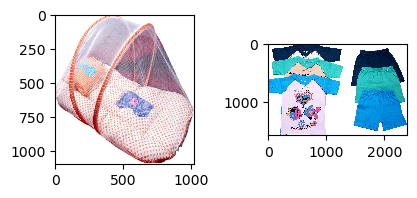

-------
Kitchen & Dining


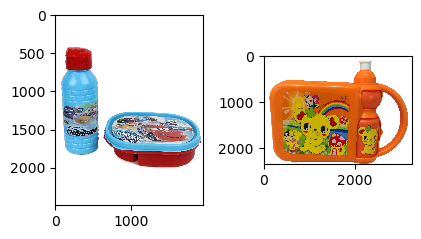

-------
Computers


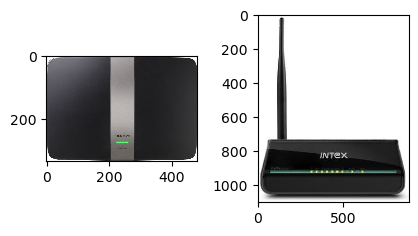

-------
Beauty and Personal Care


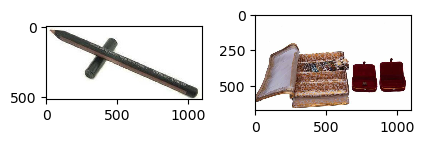

-------
Watches


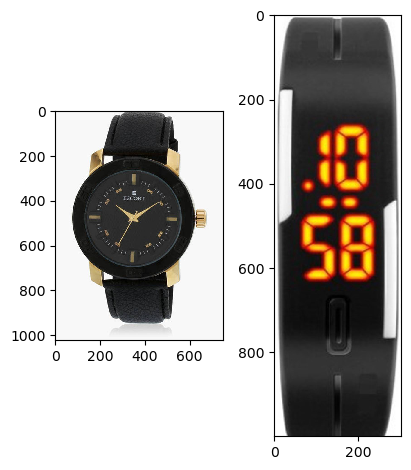

-------


In [56]:
#Affichage de deux images par catégories 
list_photos = df_img["image"]
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(df_image)) if df_image["label_name"][i] == name]
    return list_image_name

for name in list_labels :
    print("-------")
    print(name)
    for i in range(2):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        io.imshow(image)
    io.show()
print("-------")

### preprocessing image

In [81]:
# Fonction de transformation d'image 
def pretraitement_image(image):
    # Nom de l'image
    file_dir = os.path.split(image)
    #read image
    img=cv2.imread(image)
    #convert in gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #resize
    new_img = cv2.resize(gray, (224, 224))
    #removing the noise 
    noiseless_image= cv2.fastNlMeansDenoising(new_img, None, 20, 7, 21)
    #equalize
    eq = cv2.equalizeHist(noiseless_image)
    # Sauvegarde de l'image dans le répertoire Images_process
    cv2.imwrite('./Image_process/' + file_dir[1], eq)
    
    return './Image_process/' + file_dir[1]

    

In [82]:
# Transformation de l'ensemble des images du dataset
df_image['new_images']=df_img["image_loc"].apply(pretraitement_image)

#### Exemple de transformation d'image 

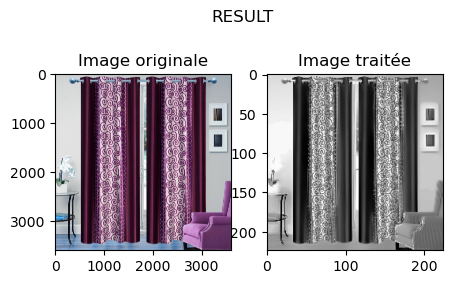

In [83]:
image_originale= cv2.imread(df_img['image_loc'][0])
new_exemple=cv2.imread(df_image['new_images'][0])
                                              
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)


ax[0].set_title('Image originale', fontsize=12)
ax[1].set_title('Image traitée', fontsize=12)


ax[0].imshow(image_originale)
ax[1].imshow(new_exemple)

### Description des features avec SIFT

L'étape fondamentale de la méthode proposée par Lowe consiste à calculer ce que l'on appelle les « descripteurs SIFT » des images à étudier. Il s'agit d'informations numériques dérivées de l'analyse locale d'une image et qui caractérisent le contenu visuel de cette image de la façon la plus indépendante possible de l'échelle (« zoom » et résolution du capteur), du cadrage, de l'angle d'observation et de l'exposition (luminosité). 

#### Exemple de détermination et affichage des descripteurs SIFT

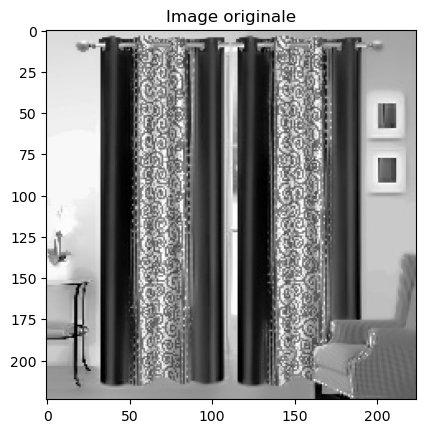

------- 


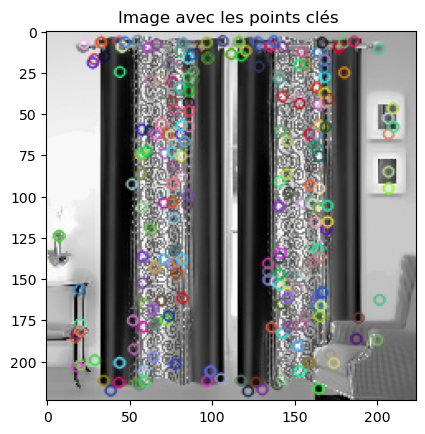

Descripteurs :  (246, 128)

[[ 0.  0.  0. ...  2.  3.  4.]
 [ 0.  0.  1. ...  0.  0.  0.]
 [ 0. 12. 15. ...  1.  1. 24.]
 ...
 [ 0.  2. 27. ...  0.  0.  3.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  5. 51. ...  0.  0.  2.]]


In [90]:
#Détermination et affichage des descripteurs SIFT
exemple=df_image['new_images'][0]
sift = cv2.SIFT_create()
image= cv2.imread(exemple)
#image_s = cv2.imread(exemple,cv2.IMREAD_GRAYSCALE) # convert in gray
#image_s = cv2.equalizeHist(image_s)   # equalize image histogram
# Applying SIFT detector
kp, des = sift.detectAndCompute(image, None)
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(cv2.imread(exemple))
plt.title('Image originale')
plt.show()
print("------- ")

plt.imshow(img)
plt.title("Image avec les points clés ")
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

#### Créations des descripteurs de chaque image

In [61]:
list_photos=df_image['new_images']

#Pré-traitement des images via SIFT
# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(9000)


for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(list_photos[image_num])
    #convert in gray
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (189247, 128)
temps de traitement SIFT descriptor :            13.25 secondes


C:\Users\mr_ar\AppData\Local\Temp\ipykernel_2788\2470931969.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


#### Création des clusters de descripteurs

In [62]:
#Création des clusters de descripteurs
#Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Nombre de clusters estimés :  435
Création de 435 clusters de descripteurs ...
temps de traitement kmeans :             5.89 secondes


#### Création des features des images

In [63]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            48.99 secondes


#### Reduction de dimension

In [64]:
#Reduction de dimensions
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 435)
Dimensions dataset après réduction PCA :  (1050, 366)


In [65]:
# Fonctions communes:

def fonction_tsne(features):
    #Réduction de dimension T-SNE

    tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(features)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df_image["label_name"]
    
    #Création de clusters à partir du T-SNE
    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=6)
    cls.fit(X_tsne)
    
    df_tsne["cluster"] = cls.labels_
    labels = df_image["label"]
    ARI=metrics.adjusted_rand_score(labels, cls.labels_)
    print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
    duration1=time.time()-temps1
    print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")
    return ARI, X_tsne, cls.labels_ ,df_tsne



# visualisation du Tsne selon les vraies catégories et selon les clusters

def visualisation_tsne(df_tsne):
    plt.figure(figsize=(8,5))
    ax = fig.add_subplot(121)
    sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    plt.title('Représentation selon les vraies classes', fontsize = 15, pad = 20, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(title='categories', bbox_to_anchor=(1, 1.02),
                 loc='upper left')


    plt.show()

    plt.figure(figsize=(8,5))
    sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

    plt.title('Représentation par clusters', fontsize = 15, pad = 20, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    print('ARI',ARI)
    return 
    


Réduction de dimension T-SNE 
-----------------


C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.0326245347301115
temps de T-SNE :            66.65 secondes

visualisation du Tsne selon les vraies catégories et selon les clusters 
-----------------


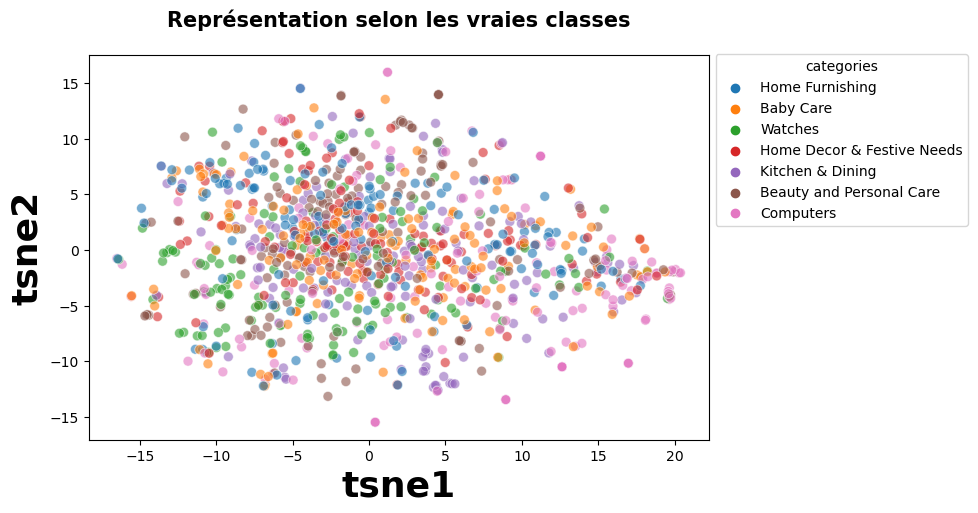

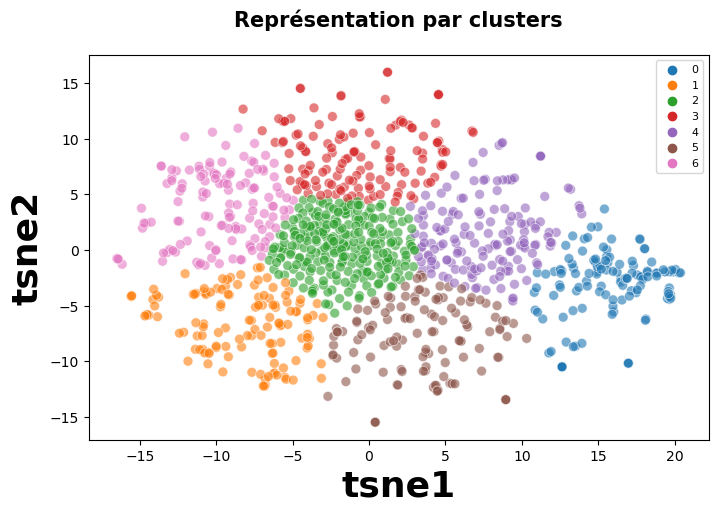

ARI 0.0326245347301115


In [66]:
print("Réduction de dimension T-SNE ")
print("-----------------")
ARI, X_tsne, labels_ ,df_tsne=fonction_tsne(feat_pca)
print()
print("visualisation du Tsne selon les vraies catégories et selon les clusters ")
print("-----------------")
visualisation_tsne(df_tsne)

#### Analyse par catégories

In [67]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    125
1    131
2    250
3    136
4    157
5    122
6    129
Name: class, dtype: int64

In [68]:
conf_mat = metrics.confusion_matrix(labels, labels_)
print(conf_mat)

[[ 9 12 47 13 24 15  5]
 [25 18 41 21 42 14 32]
 [ 9 10 50 21 30 24 21]
 [10 40 28 20 10 25 22]
 [23 22 20 44 16 15 13]
 [16 17 37 10 18 14 24]
 [33 12 27  7 17 15 12]]


In [69]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [0,1,2,3,4,5,6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 3 2 4 1 3 1]
[[ 0 29 47 27 13  0  9]
 [ 0 74 41 32 21  0 25]
 [ 0 51 50 34 21  0  9]
 [ 0 32 28 65 20  0 10]
 [ 0 29 20 37 44  0 23]
 [ 0 42 37 31 10  0 16]
 [ 0 29 27 27  7  0 33]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.26      0.38      0.31       193
           2       0.20      0.30      0.24       165
           3       0.26      0.42      0.32       155
           4       0.32      0.29      0.30       153
           5       0.00      0.00      0.00       136
           6       0.26      0.27      0.27       123

    accuracy                           0.25      1050
   macro avg       0.19      0.24      0.21      1050
weighted avg       0.19      0.25      0.22      1050



C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: title={'center': ' Matrice de confusion pour SIFT'}>

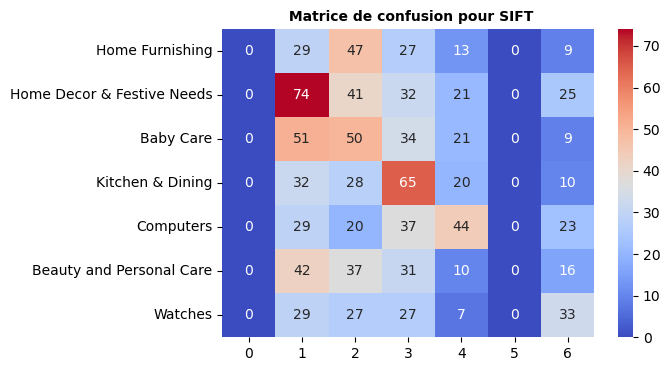

In [70]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title(" Matrice de confusion pour SIFT", fontsize=10, fontweight="bold")
sns.heatmap(df_cm, annot=True, fmt="d", cmap='coolwarm')

### CNN- Les réseaux de neurones convolutifs

Un réseau neuronal convolutif se compose de deux types de neurones artificiels, agencés en « couches » traitant successivement l'information :
- les neurones de traitement, qui traitent une portion limitée de l'image (appelée « champ réceptif ») au travers d'une fonction de convolution.
- les neurones de mise en commun des sorties dits de pooling (totale ou partielle).

Un traitement correctif non linéaire et ponctuel peut être appliqué entre chaque couche pour améliorer la pertinence du résultat.
L'ensemble des sorties d'une couche de traitement permet de reconstituer une image intermédiaire, qui servira de base à la couche suivante.

#### Transfert learning model VGG-16

le VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

Il prend en entrée une image en couleurs de taille 224  ×
 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes. 



In [71]:
#Création du modèle pré-entraîné
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### Création des features des images

In [72]:
images_features = []
i=0 
for image_file in path+df_image["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\mr_ar\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

In [73]:
# Association des features à chaque image
df_image['vgg16'] = [images_features[i] for i in range(df_image.shape[0])]
# Dataframe de travail
df_vgg16= df_image.copy()
# Constituer le dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(images_features)

### Réduction dimension et analyse

#### Réduction de dimension PCA

In [91]:
#PCA
print("Dimensions dataset avant réduction PCA : ",images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ",feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


#### Réduction de dimension T-SNE 

Réduction de dimension T-SNE 
-----------------


C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


ARI :  0.4555580632809767
temps de T-SNE :           552.98 secondes

visualisation du Tsne selon les vraies catégories et selon les clusters 
-----------------


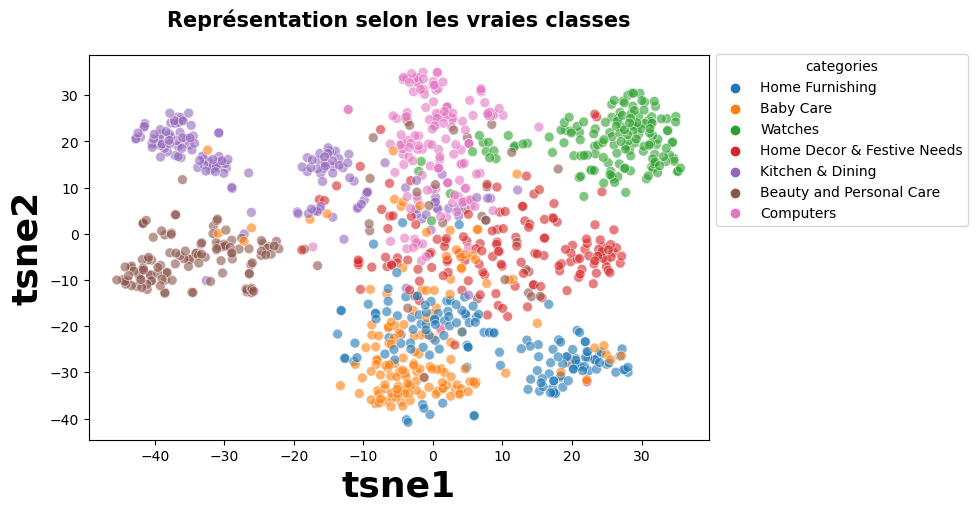

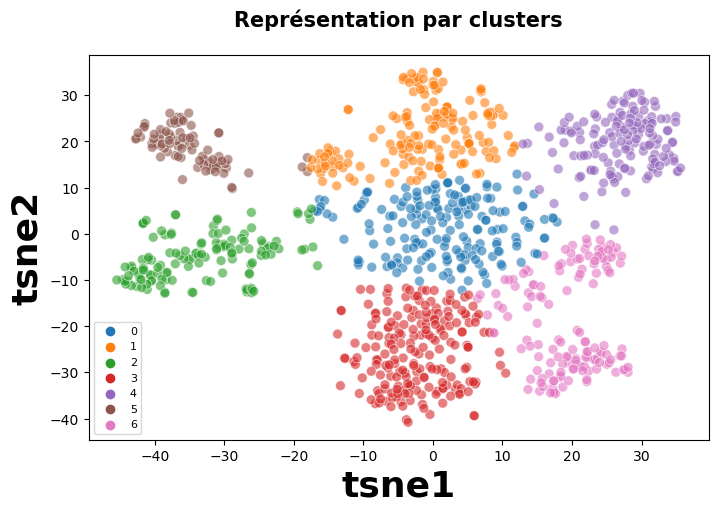

ARI 0.4555580632809767


In [75]:
print("Réduction de dimension T-SNE ")
print("-----------------")
ARI, X_tsne, labels_,df_tsne=fonction_tsne(feat_pca)
print()
print("visualisation du Tsne selon les vraies catégories et selon les clusters ")
print("-----------------")
visualisation_tsne(df_tsne)

In [76]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    185
1    165
2    130
3    202
4    145
5     83
6    140
Name: class, dtype: int64

#### Analyse par catégories

In [77]:

cls_labels_transform = conf_mat_transform(labels, labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 4 4 1 3 2 1]
[[  0  41   1   5  35   0  43]
 [  0 166   1   2   4   0  20]
 [  0  23  79   1  18   0  44]
 [  0   0   0 136  17   0   2]
 [  0   2   1   0 146   0   4]
 [  0 104   0   0  23   0   9]
 [  0   6   1   1  52   0  63]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.49      0.86      0.62       193
           2       0.95      0.48      0.64       165
           3       0.94      0.88      0.91       155
           4       0.49      0.95      0.65       153
           5       0.00      0.00      0.00       136
           6       0.34      0.51      0.41       123

    accuracy                           0.56      1050
   macro avg       0.46      0.53      0.46      1050
weighted avg       0.49      0.56      0.49      1050



C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mr_ar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: title={'center': ' Matrice de confusion pour VGG16'}>

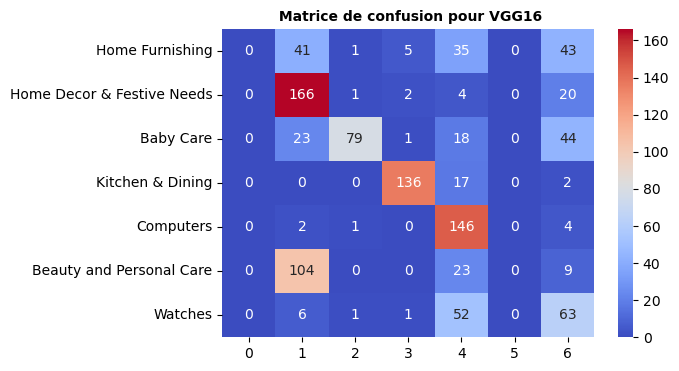

In [78]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title(" Matrice de confusion pour VGG16", fontsize=10, fontweight="bold")  
sns.heatmap(df_cm, annot=True,fmt="d" ,cmap='coolwarm')
 